The case of constant anisotropy in the velocity distribution of a dSphs stellar component is realised by the Charbonnier profile, which reads:
\begin{equation}
\beta(r)=\beta
\end{equation}

In this case, the projected line-of-sight velocity dispersion is given by:
\begin{equation}
\sigma^2_{l.o.s.}(R) = 2G\mu_0\frac{\gamma^{1-2\beta}}{I(R)} \int^\infty_1 \left(1-\frac{\beta}{z^2}\right)\frac{z^{1-2\beta}}{\sqrt{z^2-1}}\int^\infty_{z\gamma}y^{2\beta-2}\nu_\ast(y)\mu(y\alpha)dydz
\end{equation}
where $\gamma = \frac{R}{r_h}$ and $\alpha = \frac{r_h}{r_0}$

In [1]:
import yaml
import numpy as np
from os import mkdir
from sys import argv
from AT import get_data
from scipy import special
from matplotlib import pylab as plt
from scipy.integrate import quad
from math import sqrt,cos, log10, pi
from scipy import optimize as sciopt
from scipy.interpolate import UnivariateSpline as spline
from scipy.interpolate import interp1d as interp
from functions_simCA import integral2, Jfactor,nu
from multiprocessing import Pool
%matplotlib inline

In [2]:
# enter size of Mock dataset (options 100,1000,10000)
MockSize = 100

In [3]:
# inverse hyperbolic cosecant (used for gamma* = 1 , non-Plum)
def inv_csch(x):
    return np.log(np.sqrt(1+x**-2.)+x**-1.)
# integrand of I(R) (used for gamma* = 0.1 , Plum)
def integrand_I(r,rh,R):
    return nu(r/rh)*r/np.sqrt(r**2-R**2)

# dwarf surface brightness profile
def I(R,rh):
    return rh**2*((2*rh**2+R**2)*inv_csch(R/rh)-rh*np.sqrt(rh**2+R**2))/(rh**2+R**2)**(3/2.) # for gamma*=1 , non-Plum
    #return 2*quad(integrand_I,R,+np.inf,args=(rh,R))[0] # for gamma*=0.1 , Plum

In [4]:
# Mock data preparation
homedir = '/home/andrea/Desktop/work/DWARF/Jvalue/test/'
casedir = 'Isotrop_Cusp_nonPlum'
data = '/gs100_bs050_rcrs025_rarcinf_cusp_0064mpc3_df_%i_0.dat'%MockSize
err  = '/gs100_bs050_rcrs025_rarcinf_cusp_0064mpc3_df_%i_0_err.dat'%MockSize
x,y,z,vx,vy,vz = np.loadtxt(homedir+casedir+data,unpack=True)
R = np.sqrt(x**2+y**2) # assumed direction of observation along z-axis for simplicity (as suggested on the Gaia wiki)
D=50.
d = np.sqrt(x**2+y**2+(D-z)**2)
v = (x*vx+y*vy+(D-z)*vz)/d
# Errors (from mock data) preparation
Evx,Evy,Evz = np.loadtxt(homedir+casedir+err,unpack=True,usecols=(3,4,5))
Ex,Ey,Ez = np.absolute(Evx-vx),np.absolute(Evy-vy),np.absolute(Evz-vz)
dv = (x*Ex+y*Ey+(D-z)*Ez)/d

In [5]:
u=0.
rh=0.25
nstars=np.size(R)

In [6]:
gamma_array = R/rh
beta_array = np.linspace(-10,10,200)
r0_array = np.logspace(-3,1,200)
alpha_array = rh/r0_array
A_array = np.array([[gamma_array[i]**(1-2*beta)/I(Ri,rh) for beta in beta_array] for i,Ri in enumerate(R)])
I_array=np.zeros(shape=(len(A_array),len(beta_array),len(r0_array)))

In [7]:
def array_builder(gamma_array, beta_array, alpha_array):
    for k,gamma in enumerate(gamma_array):
        for i,beta in enumerate(beta_array):
            for j,alpha in enumerate(alpha_array):
                yield (k, i, j), (gamma,beta,alpha)

def proxy(args):
    return args[0], A_array[args[0][0],args[0][1]]*integral2(*args[1])

In [ ]:
pool = Pool(processes=4)
results = pool.map(proxy, array_builder(gamma_array, beta_array, alpha_array))
pool.close()
pool.join()
for idx,value in results:
    I_array[idx] = value

In [ ]:
np.save('Iarray_CA_Cusp_nonPlum_100_31_10_200',I_array)

In [8]:
Jf = np.sqrt([Jfactor(D,np.inf,r0,1.,0.5) for r0 in r0_array])

cst = 8.*np.pi*4.3e-6
# Likelihood definition (for free beta)
def logLike(J,i,j):
    I = cst*sqrt(J)*r0_array[j]**3*I_array[:,i,j]/Jf[j]
    S = dv**2.+I
    res = (np.log(S) + (v-u)**2./S).sum()
    return res/2.

/usr/lib/python2.7/dist-packages/scipy/integrate/quadpack.py:295: UserWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg)
/usr/lib/python2.7/dist-packages/scipy/integrate/quadpack.py:295: UserWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  warnings.warn(msg)
/usr/lib/python2.7/dist-packages/scipy/integrate/quadpack.py:295: UserWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  warnings.warn(msg)
/usr/lib/python2.7/dist-packages/scipy/integrate/quadpack.py:295: UserWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty c

In [13]:
J_array = np.linspace(17,21,100)
J_new = np.empty([0])
min_LikeJ = np.empty([0])
min_r0_arr = np.empty([0])
min_beta_arr = np.empty([0])

for J in J_array:                                                    # scan over an array of J values
    LikeJr0 = np.empty([0])
    r0_new = np.empty([0])
    beta_new = np.empty([0])
    for j,r0 in enumerate(r0_array):                                 # for each J scan over an array of r0 values
        LikeJb = np.zeros_like(beta_array)
        for i in range(beta_array.size): LikeJb[i] = logLike(10**J,i,j) # likelihood evaluation for each (r0,rho0)
        interp_Like_beta = interp(beta_array,LikeJb)                     # build the profile likelihood along ra
        
        eval_Like_beta = np.linspace(beta_array.min(),beta_array.max(),1e3)
        min_Like_beta = interp_Like_beta(eval_Like_beta).min()
        min_beta = eval_Like_beta[np.where(interp_Like_beta(eval_Like_beta)==min_Like_beta)[0]]
        
        if beta_array[1]<min_beta<beta_array[-2]:
            LikeJr0 = np.append(LikeJr0,min_Like_beta)
            beta_new = np.append(beta_new,min_beta)
            r0_new = np.append(r0_new,r0)
    
    if LikeJr0.size>3:
        interp_beta = interp(r0_new,beta_new)
        interp_Like_r0 = interp(r0_new,LikeJr0)                     # build the profile likelihood along r0
        
        eval_Like_r0 = np.logspace(log10(r0_new.min()),log10(r0_new.max()),1e3)
        min_Like_r0 = interp_Like_r0(eval_Like_r0).min()
        min_r0 = eval_Like_r0[np.where(interp_Like_r0(eval_Like_r0)==min_Like_r0)[0]]
        
        if r0_new[1]<min_r0<r0_new[-2]:
            plt.semilogx(r0_new,interp_Like_r0(r0_new),label='J=%.2f'%J)
            plt.plot(min_r0,min_Like_r0,'*',markersize=10,c='k')

            min_beta_arr = np.append(min_beta_arr,interp_beta(min_r0))
            min_LikeJ = np.append(min_LikeJ,min_Like_r0)
            min_r0_arr = np.append(min_r0_arr,min_r0)
            J_new = np.append(J_new,J)

#plt.ylim(310,330)
#plt.xlim(1e-2,1e0)
#plt.legend(bbox_to_anchor=(1.4,1))

NameError: name 'logLike' is not defined

min J =  19.12  , ra =  0.074  , r0 =  156.188


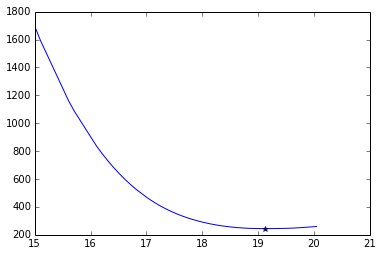

In [16]:
interp_Like = spline(J_new,min_LikeJ,k=2)
interp_Like_r0 = interp(J_new,min_r0_arr)
interp_Like_beta = interp(J_new,min_beta_arr)
min_J = sciopt.minimize_scalar(interp_Like,method='Bounded',bounds=(J_new[0],J_new[-1])).x
min_beta = interp_Like_beta(min_J)
J_r0 = interp_r0(min_J)
print 'min J = ',round(min_J,2),' , beta = ',round(min_beta,3),' , r0 = ',round(J_r0,3)
plt.plot(J_new,interp_Like(J_new))
plt.plot(min_J,interp_Like(min_J),'b*')
#plt.ylim(240,260)

In [17]:
def one_sigmaJ(J):
    return np.abs(interp_Like(J)-interp_Like(min_J)-0.5)

one_sigma_l = sciopt.minimize_scalar(one_sigmaJ,method='Bounded',bounds=(min_J-1,min_J)).x-min_J
one_sigma_r = sciopt.minimize_scalar(one_sigmaJ,method='Bounded',bounds=(min_J,min_J+1)).x-min_J

def two_sigmaJ(J):
    return np.abs(interp_Like(J)-interp_Like(min_J)-2.)

two_sigma_l = sciopt.minimize_scalar(two_sigmaJ,method='Bounded',bounds=(min_J-1,min_J)).x-min_J
two_sigma_r = sciopt.minimize_scalar(two_sigmaJ,method='Bounded',bounds=(min_J,min_J+1)).x-min_J

def three_sigmaJ(J):
    return np.abs(interp_Like(J)-interp_Like(min_J)-4.)

three_sigma_l = sciopt.minimize_scalar(three_sigmaJ,method='Bounded',bounds=(min_J-1,min_J)).x-min_J
three_sigma_r = sciopt.minimize_scalar(three_sigmaJ,method='Bounded',bounds=(min_J,min_J+1)).x-min_J


In [18]:
print round(min_J,2),round(one_sigma_l,2),round(one_sigma_r,2),round(two_sigma_l,2),\
round(two_sigma_r,2),round(three_sigma_l,2),round(three_sigma_r,2)

19.12 -0.14 0.17 -0.27 0.38 -0.37 0.51


In [19]:
trueJ = round(np.log10(Jfactor(D,np.inf,1.,6.4e7,0.5)),2)
print 'true J : ',trueJ,', obtained J : ',round(min_J,2)

true J :  19.36 , obtained J :  19.12


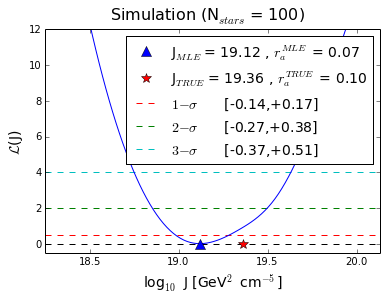

In [20]:
J_plt = np.linspace(min_J+three_sigma_l-0.5,min_J+three_sigma_r+0.5,100)
plt.plot(J_plt,interp_Like(J_plt)-interp_Like(min_J))
plt.plot(min_J,0,'b^',markersize=10,label='J$^{MLE}$ = %.2f'%min_J+r' , $\beta^{MLE}$ = %.2f'%round(min_beta,3))
plt.plot(trueJ,0,'r*',markersize=10,label='J$^{TRUE}$ = %.2f'%trueJ+r' , $\beta^{TRUE}$ = %.2f'%rh)
plt.hlines(0.,min(J_plt),max(J_plt),linestyles='dashed')
plt.hlines(.5,min(J_plt),max(J_plt),colors=('r'),linestyles='dashed',
           label=r'$1-\sigma$'+'\t'+'[%.2f,%+.2f]'%(one_sigma_l,one_sigma_r))
plt.hlines(2,min(J_plt),max(J_plt),colors=('g'),linestyles='dashed',
           label=r'$2-\sigma$'+'\t'+'[%.2f,%+.2f]'%(two_sigma_l,two_sigma_r))
plt.hlines(4,min(J_plt),max(J_plt),colors=('c'),linestyles='dashed',
           label=r'$3-\sigma$'+'\t'+'[%.2f,%+.2f]'%(three_sigma_l,three_sigma_r))
plt.legend(numpoints=1,fontsize=14).get_frame().set_facecolor('w')
plt.ylabel(r'$\mathcal{L}$(J)',fontsize=14)
plt.xlabel(r'log$_{10}$  J [GeV$^2$ cm$^{-5}$]',fontsize=14)
plt.ylim(-0.5,12)
plt.xlim(min_J+three_sigma_l-0.5,min_J+three_sigma_r+0.5)
#plt.savefig(homedir+casedir+'/Sim%i_%s.png'%(nstars,casedir),dpi=300,format='png')
plt.suptitle(r'Simulation (N$_{stars}$ = %i)'%nstars,fontsize=16)
#plt.savefig(homedir+casedir+'/Sim%i_%s_title.png'%(nstars,casedir),dpi=300,format='png')

In [17]:
J_rho0 = sciopt.minimize_scalar(lambda log10rho0:abs(min_J-np.log10(Jfactor(D,np.inf,J_r0,1.,0.5))-2*log10rho0)).x
print '%15s %15s'%('True','Best fit')
print '%5s %10.2f %15.3f'%('r0',1.,J_r0)
print '%5s %10.2e %15.3e'%('rho0',4e8,10**J_rho0)

           True        Best fit
   r0       1.00        3726.440
 rho0   4.00e+08       9.405e+03
